In [0]:
import pandas as pd
import numpy as np

In [0]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [0]:
import requests
from bs4 import BeautifulSoup

Web Scrawler

In [0]:
target = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
req = requests.get(url = target)
html = req.text
bf = BeautifulSoup(html,'lxml')
bf.find_all("tbody") 

main = bf.find_all('table',class_ = "wikitable sortable") 
bf_tr = BeautifulSoup(str(main),'lxml')
str_tr = bf_tr.find_all('tr')
Postcode = []
Borough = []
Neighbourhood = [] 
for mm in str_tr[1:]:
  Postcode.append(BeautifulSoup(str(mm),'lxml').find_all('td')[0].get_text())
  Borough.append(BeautifulSoup(str(mm),'lxml').find_all('td')[1].get_text())
  Neighbourhood.append(BeautifulSoup(str(mm),'lxml').find_all('td')[2].get_text().replace("\n",""))

*   The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
*   Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
*   More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
*   If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
*   Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
*   In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [0]:
pan = {"Postcode":Postcode,"Borough":Borough,"Neighbourhood":Neighbourhood}
df = pd.DataFrame(pan)
df = df.drop(df[df["Borough"] == "Not assigned"].index)
df["Neighbourhood"] = df.apply((lambda x: x["Neighbourhood"] if x["Neighbourhood"] != "Not assigned" else x["Borough"]),axis = 1)

In [0]:
df_new = df.groupby(["Postcode",'Borough']).count()

In [0]:
df_new["Postcode"] = " "
df_new["Borough"] = " "
df_new["Neighbourhood"] = " "
for pos,bor in df_new.index:
  df_new["Postcode"].loc[(pos,bor)] = pos
  df_new["Borough"].loc[(pos,bor)] = bor
  df_new["Neighbourhood"].loc[(pos,bor)] = ",".join(list(df["Neighbourhood"][df["Postcode"]==pos]))
  

In [0]:
df_new = df_new.reset_index(drop=True)

In [152]:
df_new

,Neighbourhood,Postcode,Borough
0,"Rouge,Malvern",M1B,Scarborough
1,"Highland Creek,Rouge Hill,Port Union",M1C,Scarborough
2,"Guildwood,Morningside,West Hill",M1E,Scarborough
3,Woburn,M1G,Scarborough
4,Cedarbrae,M1H,Scarborough
...,...,...,...
98,Weston,M9N,York
99,Westmount,M9P,Etobicoke
100,"Kingsview Village,Martin Grove Gardens,Richvie...",M9R,Etobicoke
101,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",M9V,Etobicoke


#build new dataframe conclude geographical coordinates

In [0]:
df_geo = pd.read_csv("Geospatial_Coordinates.csv")

In [0]:
df_geo.columns = ["Postcode","Latitude","Longitude"]

In [155]:
df_fin = df_geo.merge(df_new,how = "left", on = ["Postcode"])
df_fin

,Postcode,Latitude,Longitude,Neighbourhood,Borough
0,M1B,43.806686,-79.194353,"Rouge,Malvern",Scarborough
1,M1C,43.784535,-79.160497,"Highland Creek,Rouge Hill,Port Union",Scarborough
2,M1E,43.763573,-79.188711,"Guildwood,Morningside,West Hill",Scarborough
3,M1G,43.770992,-79.216917,Woburn,Scarborough
4,M1H,43.773136,-79.239476,Cedarbrae,Scarborough
...,...,...,...,...,...
98,M9N,43.706876,-79.518188,Weston,York
99,M9P,43.696319,-79.532242,Westmount,Etobicoke
100,M9R,43.688905,-79.554724,"Kingsview Village,Martin Grove Gardens,Richvie...",Etobicoke
101,M9V,43.739416,-79.588437,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Etobicoke


#Do cluster part

In [0]:
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 

#### landencoding

drop Neighbourhood	list

In [0]:
df_cl = df_fin.drop("Neighbourhood",axis = 1)

In [0]:
from sklearn.preprocessing import LabelEncoder
# process columns, apply LabelEncoder to categorical features
for c in df_cl.columns:
  if str(df_cl[c].dtype) == "object":
    lbl = LabelEncoder() 
    lbl.fit(list(df_cl[c].values)) 
    df_cl[c] = lbl.transform(list(df_cl[c].values))

#### k_means

Train

In [172]:
# for k in range(1,6):
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)
k_means.fit(df_cl)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

get labels

In [173]:
k_means_labels = k_means.labels_
k_means_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

get center

In [174]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[ 64.        ,  43.66888228, -79.40192923,   2.4       ],
       [ 12.5       ,  43.76925133, -79.29592678,   6.65384615],
       [ 89.5       ,  43.66905545, -79.50596061,   5.42307692],
       [ 38.5       ,  43.70986782, -79.38497873,   3.03846154]])

Draw a picture

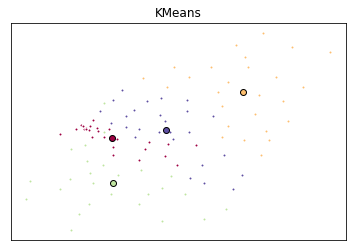

In [180]:

# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(df_cl["Latitude"].loc[my_members], df_cl["Longitude"].loc[my_members], 'w+', markerfacecolor=col, marker='.')
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[1], cluster_center[2], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()